**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!apt install libgraphviz-dev pkg-config # to fix broken installation of pygraphviz
!{sys.executable} -m pip install pygraphviz==1.7
!{sys.executable} -m pip install git+https://gitlab.com/michalgregor/ani_torch.git

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
from sympy.utilities.lambdify import lambdify
from scipy.optimize import approx_fprime
from ani_torch import TorchGraph
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sympy as sp
import torch
import time

sp.init_printing(use_latex='matplotlib')

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
def sp_sum(x):
    return x

## Different Ways to Automatically Compute Gradient: A Comparison

We have so far encountered no less than three different ways to automatically compute gradients of mathematical expressions:

* symbolic differentiation;
* numerical differentiation;
* automatic differentiation (autodiff).
### Symbolic Differentiation

In the case of symbolic differentiation, we would define the expression symbolically (e.g. using the `sympy` package) and then derive its gradient in the symbolic form. This would then be converted into a standard python function and used to compute the gradients. Unfortunately, symbolic differentiation does not scale too well to complex expressions, because when the gradient of these is derived the result tends to have a huge amount of subexpressions that repeat again and again and that need to be recomputed all the time. Also, scaling to a large number of dimensions can be a problem, because that further multiplies the number of operations required.

### Numeric Differentiation

With numeric differentiation, we do not need a symbolic expression: all we need is a function that we can evaluate. As such, numeric differentiation will not have the same scaling problem that symbolic differentiation faces (however, the character of the expression can have a significant impact on the precision of the computed gradients). The gradient is approximated numerically by perturbing the point of interest and measuring the differences. The technique can even be applied to functions which are not in fact differentiable. However, numeric differentiation does not scale at all well with the number of dimensions. While it can be relatively effective for low-dimensional problems, its cost grows very fast with an increasing number of dimensions. This is because the point needs to be perturbed along every dimension to determine how fast the function changes along it. This means that the function will need to be evaluated a huge number of times.

### Automatic Differentiation

Finally, in the case of automatic differentiation, the interface does not look very different to that of symbolic differentiation, but the gradient is not in fact computed symbolically. Instead, we construct a graph of the expression, run it forward to get the output and then run it backward, propagating the gradients from the output back to the input. The cost of automatic differentiation is therefore only approximately 2 times the cost of the forward run. The graph allows the algorithm to cache and reuse intermediate results in a way that symbolic differentiation cannot. (This is related to a technique known as dynamic programming: autodiff is basically the combination of the chain rule and dynamic programming.)

### The Expression That We Are Going to Differentiate

The expression that we will be evaluating will be formed by stacking instances of a simpler subexpression on top of each other. The subexpression is displayed here:



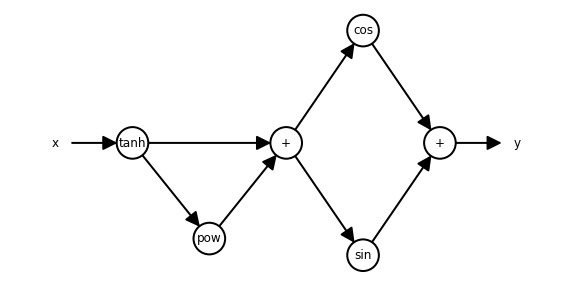



### Autodiff using PyTorch

We will start by defining the subexpression as a PyTorch function.



In [ ]:
def torch_layer(x):
    y = torch.tanh(x)
    y1 = y ** 2
    y = y1 + y
    
    y1 = torch.cos(y)
    y2 = torch.sin(y)
    y = y1 + y2
    
    return y

As the next step we will stack several instances of `torch_layer` to form our full expression. We will also apply function `sum` to the result: if the output is a vector or a matrix, we will compute the gradient of the sum of their elements.



In [ ]:
def torch_func(x):
    y = torch_layer(x)
    y = torch_layer(y)
    y = torch_layer(y)
    y = torch_layer(y)
    y = torch.sum(y)
    
    return y

Finally, we will define the `torch_grad` function that will automatically compute the gradient by running `torch_func` forward and backward.



In [ ]:
def torch_grad(x):
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    y = torch_func(x)
    y.backward()
    return x.grad.numpy()

To test whether our function works, we can now invoke for some particular input $x$. The output will be a `numpy` array containing our scalar output. We will use its `.item` method to extract the scalar number to make the output more readable.



In [ ]:
torch_grad(0.01).item()

In [ ]:
torch_grad(np.full((3, 3), 0.01))

#### Displaying the Graph

Having defined our function, we can now display the resulting graph to check whether we implemented everything correctly. Let us start with the graph of the subexpression and then also display the full expression.



In [ ]:
plt.figure(figsize=(10, 5))
graph = TorchGraph(torch_layer, [0.1])
graph.plot()

In [ ]:
plt.figure(figsize=(28, 6))
graph = TorchGraph(torch_func, [0.1])
graph.plot()

### Symbolic Differentiation using SymPy

Having defined the PyTorch version of our expression, let us now move on to the symbolic version, which we will define using the `sympy` package. We will again start by defining the subexpression. The definition will be virtually identical to the PyTorch version: the only difference being that it uses the `sympy` namespace `sp` instead of the PyTorch namespace `torch`.



In [ ]:
def sym_layer(x):
    y = sp.tanh(x)
    y1 = y ** 2
    y = y1 + y

    y1 = sp.cos(y)
    y2 = sp.sin(y)
    y = y1 + y2
    
    return y

And we will again stack multiple instances of the subexpression to form our full expression. We will also again apply function `sum` to the result: if the output is a vector or a matrix, we will compute the gradient of the sum of their elements.



In [ ]:
def sym_func(x):
    y = sym_layer(x)
    y = sym_layer(y)
    y = sym_layer(y)
    y = sym_layer(y)
    y = sp_sum(y)
    
    return y

Finally, we will use symbolic differentiation to compute the gradient in the usual way and then transform into a standard python function called `sym_grad`. Even though our expression is not too large, to derive its symbolic gradient will already take a considerable amount of time. We will therefore time the execution of the next cell using the `%%time` magic command.



In [ ]:
%%time
x = sp.symbols('x')
y = sym_func(x)
sym_sym_grad = sp.Matrix([y]).jacobian([x])
sym_grad = lambdify((x), sym_sym_grad, "numpy")

Like before, we can check whether our function works by invoking it. We can also compare the result with that of `torch_grad`. They should be very similar, but may not be exactly equal due to rounding errors (we can expect the results of symbolic differentiation to be a bit less precise because a lot more operations have to be carried out to compute them and so the errors will accumulate). For simpler expressions the results would match almost exactly.



In [ ]:
sym_grad(0.01).item()

In [ ]:
sym_grad(np.full((3, 3), 0.01))

#### Displaying the Expressions

We can also check the expressions. With the sub-expression this is going to be relatively easy.



In [ ]:
sym_layer(x)

Unfortunately, the full expression will be absurdly large.



In [ ]:
str(y)

Unsurprisingly, the symbolic gradient is going to be much worse still.



In [ ]:
str(sym_sym_grad)

### Numerical Differentiation Using SciPy

For numerical differentiation, we will define the functions as standard Python functions using `numpy`. We will then use the `approx_fprime` function from the SciPy package to numerically compute the gradient. To this end we need to specify parameter epsilon: we use the same value that is used internally in SciPy by the optimization methods that use numeric gradients. Since `approx_fprime` operates on vectors (1-dimensional arrays), we will also need to do some reshaping before and after we invoke it.



In [ ]:
def np_layer(x):
    y = np.tanh(x)
    y1 = y ** 2
    y = y1 + y

    y1 = np.cos(y)
    y2 = np.sin(y)
    y = y1 + y2
    
    return y

In [ ]:
def np_func(x):
    y = np_layer(x)
    y = np_layer(y)
    y = np_layer(y)
    y = np_layer(y)
    y = np.sum(y)
    
    return y

In [ ]:
eps = np.sqrt(np.finfo(float).eps)

def np_grad(x):
    x_vec = np.hstack([np.asarray(x).reshape(-1), [1]])
    g = approx_fprime(x_vec, np_func, epsilon=eps)
    return g[:-1].reshape(np.shape(x))

Next we can again verify whether our function works. Precision of the gradient will depend on the character of the expression – in our case it should be quite good, but there are expressions (we could replace `cos` with `exp` for instance), where numerical approximation will practically fail altogether, which the other two methods will be able to achieve relatively good results.



In [ ]:
np_grad(0.01).item()

In [ ]:
np_grad(np.full((3, 3), 0.01))

### Comparing the Run Times

Finally, having set up all three methods of computing the gradients, we can now compare their run times. We will run a number of iterations for each method and measure the overall time using the `%%time` magic command. Furthermore, we will run a scalar and a matrix version of the computation for each method.

We should see that autodiff is much faster than the other two methods. Also, the effect would become much more pronounced if we increased the complexity of the expression and the dimensionality of the inputs.

#### Automatic differentiation



In [ ]:
%%time
grads = 0

for i in range(500):
    grads += torch_grad(np.random.uniform(0, 1))

In [ ]:
%%time
grads = 0

for i in range(500):
    grads += torch_grad(np.random.uniform(0, 1, (15, 15)))

#### Symbolic Differentiation



In [ ]:
%%time
grads = 0

for i in range(500):
    grads += sym_grad(np.random.uniform(0, 1))

In [ ]:
%%time
grads = 0

for i in range(500):
    grads += sym_grad(np.random.uniform(0, 1, (15, 15)))

#### Numerical Differentiation



In [ ]:
%%time
grads = 0

for i in range(500):
    grads += np_grad(np.random.uniform(0, 1))

In [ ]:
%%time
grads = 0

for i in range(500):
    grads += np_grad(np.random.uniform(0, 1, (15, 15)))

### A Graphical Comparison



In [ ]:
#@title -- Run the Experiments and Record the Results -- { display-mode: "form" }
results = []

def autodiff_test(config):
    print("running autodiff, config {}...".format(config))
    start = time.time()
    grads = 0
    for i in range(500):
        grads += torch_grad(np.random.uniform(0, 1, config))
    end = time.time()
    return end-start

def symbolic_test(config):
    print("running symbolic, config {}...".format(config))
    start = time.time()
    grads = 0
    for i in range(500):
        grads += sym_grad(np.random.uniform(0, 1, config))
    end = time.time()
    return end-start

def numerical_test(config):
    print("running numerical, config {}...".format(config))
    start = time.time()
    grads = 0
    for i in range(500):
        grads += np_grad(np.random.uniform(0, 1, config))
    end = time.time()
    return end-start

cfg = (1,)
results.append(('autodiff', cfg, autodiff_test(cfg)))
results.append(('symbolic', cfg, symbolic_test(cfg)))
results.append(('numerical', cfg, numerical_test(cfg)))

cfg = (5, 5)
results.append(('autodiff', cfg, autodiff_test(cfg)))
results.append(('symbolic', cfg, symbolic_test(cfg)))
results.append(('numerical', cfg, numerical_test(cfg)))

cfg = (10, 10)
results.append(('autodiff', cfg, autodiff_test(cfg)))
results.append(('symbolic', cfg, symbolic_test(cfg)))
results.append(('numerical', cfg, numerical_test(cfg)))

cfg = (15, 15)
results.append(('autodiff', cfg, autodiff_test(cfg)))
results.append(('symbolic', cfg, symbolic_test(cfg)))
results.append(('numerical', cfg, numerical_test(cfg)))

# make a pandas dataframe
df = pd.DataFrame(results, columns=["method", 'config_tuple', 'time [s]'])
df['input shape'] = df['config_tuple'].astype(str)

In [ ]:
sns.catplot(x="method", y="time [s]", hue="input shape",
            data=df, kind="bar", aspect=1.25)
plt.gca().set_axisbelow(True)
plt.grid(ls='--')